In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
#!python
from numpy import *
from numpy.random import *
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli
import pyparticleest.interfaces as interfaces
from scipy.optimize import newton

In [31]:
#df = pd.read_csv('thaldata.csv',header=None)
#Y = df.values.reshape(3000)
#Y = Y[500:800]
#T = len(Y)
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]

In [44]:
# Forward particles
N = 1000
# Backward trajectories
M = 30
# 
P0 = 0.01
#trial
trial = 50
#
coefficient = scipy.special.binom(trial,Y[j,:])
#
l2pi = math.log(2 * math.pi)
#
square2pi = np.sqrt(2 * math.pi)
#
sigma = 0.5
#
j = 15

In [37]:
def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices

In [38]:
def measure(X, Y, trial, t, coefficient):
    # log-pdf of p(y_t|x_t)
    return np.log(coefficient[t]) + X[t,:] * Y[t] - trial * np.log(1+np.exp(X[t,:]))

In [39]:
def forward(X, a, S, t):
    #log-pdf of p(x_t|x_{t-1})
    return -0.5 * (l2pi + np.log(S) + ((X[t,:]-a).ravel() ** 2) / S)

In [40]:
def lognormpdf_scalar(err, S):
    """
    Calculate gaussian probability density of all elements in err, when
    err[i] ~ N(0,S) and each element in err is a scalar
    """
    return -0.5 * (l2pi + np.log(S) + (err.ravel() ** 2) / S)

In [41]:
def filtering(T, N, Q, trial, coefficient, Y):
    ##Initialization
    t = 0
    X = np.empty([T,N])
    ancestor = np.empty([T,N])
    w = np.empty([T,N])
    W = np.empty([T,N])
    X[t,:] = np.random.normal(0, np.sqrt(Q), N)
    w[t,:] = measure(X, Y, trial, t, coefficient)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    ancestor[t,:]= X[t,resample(W[t,:])]
    samples = np.random.normal(0, 1, [T,N])
    for tt in range(T-1):
        t=tt+1
        a = ancestor[tt,:]
        X[t,:] = a + np.sqrt(Q) * samples[t,:] ##f(x_t|x_{t-1}) standard deviation
        w[t,:] = measure(X, Y, trial, t, coefficient) ##g(y_t|x_t)
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
        W[t,:] /= np.sum(W[t,:])
        ancestor[t,:]= X[t,resample(W[t,:])]
    
    return X, w, W, ancestor

In [45]:
Q = sigma 
[X, w, W, ancestor] = filtering(T, N, Q, trial, coefficient, Y[j,:])

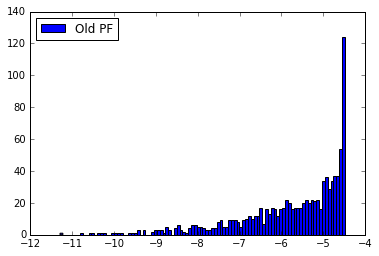

In [49]:
plt.hist(w[1000,:],100, label='Old PF')
plt.legend(loc='best')

In [12]:
def smoothing(T, N, Q, trial, M, X, W):
    w_back = np.empty([T,N])
    W_BACK = np.empty([T,N])
    smoother = np.empty([T,M])
    for j in range(M):
        myList = np.random.multinomial(1, W[T-1,:])
        smoother[T-1,j] = X[T-1, next((i for i, x in enumerate(myList) if x), None)]
    for tt in range(T-1):
        t = T-2 - tt
        for j in range(M):
            w_back = W[t,:] * np.exp(kalman.lognormpdf_scalar(smoother[t+1,j]-X[t,:], Q))
            #w_back = W[t,:] * np.exp(-(smoother[t+1,j]-X[t,:])**2/(2.0*Q))/square2pi/np.sqrt(Q)
            W_BACK[t,:] = w_back/np.sum(w_back)
            myList = np.random.multinomial(1, W_BACK[t,:])
            smoother[t,j] = X[t, next((i for i, x in enumerate(myList) if x), None)]
            
    return smoother

In [13]:
%%prun
#iterations
iteration=10
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.01
for i in range(iteration):
    P0 = sigma_ls[i] * np.eye(1)    
    Q = sigma_ls[i] * np.eye(1)
    [X, w, W, ancestor] = filtering(T, N, Q, trial, coefficient,Y)
    est_smooth = smoothing(T, N, Q, trial, M, X, W)
    posteriorcovariance=np.array(np.diff(est_smooth,axis=0))**2
    sigma_ls[i+1] = np.sum(posteriorcovariance/(M*T)) * np.eye(1)

In [53]:
a = [0,0,1,0,0]
np.nonzero(a)

(array([2]),)

In [ ]:
sigma_ls

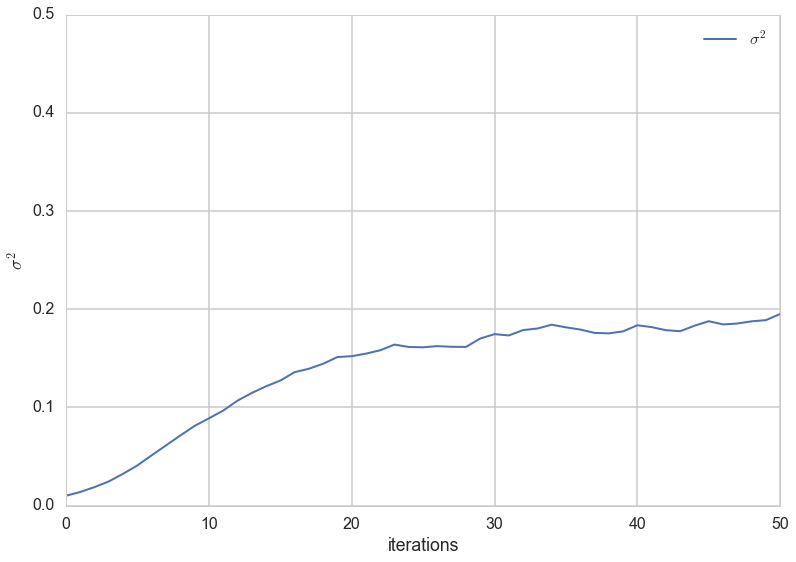

In [14]:
plt.plot(sigma_ls, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylim([0,0.5])
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

In [16]:
##Initialization
t = 0
v = np.zeros(N)
X = np.empty([T,N])
ancestor = np.empty([T,N])
w = np.empty([T,N])
W = np.empty([T,N])
X[t,:] = np.random.normal(0, np.sqrt(P0), N)
w[t,:] = measure(X, Y, trial, t, coefficient)
W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
W[t,:] /= np.sum(W[t,:])
ancestor[t,:]= X[t,resample(W[t,:])]

In [48]:
noise = np.random.normal(0, np.sqrt(P0), ([T,N]))

In [11]:
mode = np.empty(T)
variance = np.empty(T)

In [17]:
#%%prun
for tt in range(T-1):
    t=tt+1
    #samplemean = nanmean(ancestor[tt,:])
    #samplevariance = nanvar(ancestor[tt,:]) + Q
    #mode = samplemean + (samplevariance)*(Y[t] - np.exp(samplemean)/(1 + np.exp(samplemean)) * trial)
    #variance = 1.0 / (1.0/((samplevariance) + trial * np.exp(samplemean)/(1+np.exp(samplemean))**2))
    #X[t,:] = np.random.normal(mode[tt],np.sqrt(variance[tt]), N)
    #X[t,:] = mode + variance * noise[t,:]
    a = ancestor[tt,:]
    X[t,:] = a + np.random.normal(0, np.sqrt(Q), N) ##f(x_t|x_{t-1}) standard deviation
    #w = measure(X, Y, trial, t, coefficient) + forward(X, ancestor[tt,:], Q, t) - lognormpdf_scalar(X[t,:]-mode, variance)   
    w[t,:] = measure(X, Y, trial, t, coefficient) ##g(y_t|x_t)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    ancestor[t,:]= X[t,resample(W[t,:])]

In [18]:
maxlogweight = np.max(w,axis=1)
weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

-378.13438015708539

In [68]:
#%%prun
w_back = np.empty([T,N])
W_BACK = np.empty([T,N])
smoother = np.empty([T,M])
multinomialsamples = np.random.multinomial(M, W[t,:])
ancestor_nonzero = ancestor[T-1, multinomialsamples>0]
smoother[T-1,:] = np.repeat(ancestor_nonzero, multinomialsamples[multinomialsamples>0])
for tt in range(T-1):
    t = T-2 - tt
    w_back = W[t,:] * np.exp(kalman.lognormpdf_scalar(smoother[t+1,0]-ancestor[t,:], Q))
    #w_back = W[t,:] * np.exp(-(smoother[t+1,:]-X[t,:])**2/(2.0*Q))/square2pi/sqrt(Q)
    W_BACK[t,:] = w_back/np.sum(w_back)
    multinomialsamples = np.random.multinomial(M, W_BACK[t,:])
    ancestor_nonzero = ancestor[T-1, nonzero(multinomialsamples)]
    smoother[t,:] = np.repeat(ancestor_nonzero, multinomialsamples[nonzero(multinomialsamples)])

In [71]:
#np.random.multinomial(M,W_BACK)
W_BACK.shape

(300, 100)

In [57]:
a = np.random.multinomial(M, W[T-1,:])
print a
print a>0
print ancestor[T-1, a>0]

[0 2 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 2 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0 0 1 0 0 1 0 1 0 0 1
 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 2 0 0]
[False  True False False  True False  True  True  True False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False  True False  True False False False False  True
 False False False False False False False False False False False False
  True  True  True False False  True False False  True False  True False
 False  True False  True  True False  True False  True False False False
  True False False  True  True False  True False False False False False
 False  True False False]
[-2.48737147 -2.05411401 -2.53965744 -3.42937358 -2.69443567 -2.9580565
 -2.65281937 -2.8362524  -2.85367161 -2.14283395 -3.21175261 -2.91235891
 -2.35947524 -3.01065741 -2.30394957 -2.8

In [60]:
np.repeat(ancestor_nonzero,a[a>0])

array([-2.48737147, -2.48737147, -2.05411401, -2.53965744, -3.42937358,
       -2.69443567, -2.9580565 , -2.65281937, -2.8362524 , -2.8362524 ,
       -2.85367161, -2.14283395, -3.21175261, -2.91235891, -2.91235891,
       -2.35947524, -3.01065741, -2.30394957, -2.89316966, -2.50598698,
       -2.13838482, -2.5610746 , -2.42255763, -2.34984171, -3.07919787,
       -2.32061057, -2.29222516, -2.87544627, -2.73971744, -2.73971744])

In [59]:
ancestor_nonzero = ancestor[T-1, a>0]
ancestor_nonzero.reshape([-1,1])

array([[-2.48737147],
       [-2.05411401],
       [-2.53965744],
       [-3.42937358],
       [-2.69443567],
       [-2.9580565 ],
       [-2.65281937],
       [-2.8362524 ],
       [-2.85367161],
       [-2.14283395],
       [-3.21175261],
       [-2.91235891],
       [-2.35947524],
       [-3.01065741],
       [-2.30394957],
       [-2.89316966],
       [-2.50598698],
       [-2.13838482],
       [-2.5610746 ],
       [-2.42255763],
       [-2.34984171],
       [-3.07919787],
       [-2.32061057],
       [-2.29222516],
       [-2.87544627],
       [-2.73971744]])

In [34]:
[nonzero(a)] * a[nonzero(a)]

array([[[  4,   7,   8,  18,  12,  14,  18,  22,  31,  47,  48,  51,  56,
         116, 134,  69, 140,  71,  83,  86,  89, 182, 184,  96]]])

In [159]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
#mat = np.loadtxt('train_data.txt')
#Y = mat[19,1:]
T = len(Y)

In [142]:
#iterations
iteration=50
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.1

In [ ]:
#iterations
iteration=50
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.1
for i in range(iteration):
    P0 = sigma_ls[i] * np.eye(1)    
    Q = sigma_ls[i] * np.eye(1)
    model = StdNonLin(P0, Q)
    sim = simulator.Simulator(model,u=None,y=Y)
    sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
    est_smooth = sim.get_smoothed_estimates()
    posteriorcovariance=np.array(np.diff(est_smooth[:,:,0],axis=0))**2
    sigma_ls[i+1] = np.sum(posteriorcovariance/(M*T)) * np.eye(1)

In [ ]:
print measure(X, Y, trial, 1000, coefficient)
print coefficient[1000]
print forward(X, ancestor[999,:], Q, 1000)
print lognormpdf_scalar(X[1000,:]-mode, variance)

In [ ]:
## for t > 0
for tt in range(1):
    t=tt+1
    a = ancestor[t,:]
    mode = a + t*Q*(Y[t] - np.exp(a)/(1 + np.exp(a)) * (Y[t] - trial * (1+np.exp(a))))
    variance = 1.0 / (t*Q + Y[t]*np.exp(a)/(1+np.exp(a))**2 + trial * np.exp(a)*(1-np.exp(a))/(1+np.exp(a))**3)
    X[t,:] = np.random.normal(mode,variance)
    w[t,:] = measure(X, Y, trial, t, coefficient) + forward(X, a, Q, t) - lognormpdf_scalar(X[t,:]-mode, variance)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    ancestor[t+1,:]= X[t,resample(W[t,:])]

In [ ]:
1.0 / (t*Q + Y[t]*np.exp(a)/(1+np.exp(a))**2 + trial * np.exp(a)*(1-np.exp(a))/(1+np.exp(a))**3)

In [ ]:
np.exp(a)*(1-np.exp(a))/(1+np.exp(a))**3

In [ ]:
ancestor[1,:]

In [ ]:
signal.resample()

In [ ]:
def h(x):
    return x - ancestor + t*Q *(y[t] - np.exp(x)/(1+np.exp(x)))/(1+np.exp(x))

def dh(x):
    return 1 - t * Q

In [ ]:
def k(x):
    return x**3 -1

In [ ]:
def dk(x):
    return 3*x**2

In [ ]:
x0=0.4
print newton(k, x0, dk)

In [23]:
print scipy.stats.norm.pdf(0.5,1)
print np.exp(-0**2/2)/(np.sqrt(2*np.pi))

0.352065326764
0.398942280401


In [ ]:
X = np.empty([T,N])
ancestor = np.empty([T,N])
w = np.empty([T,N])
W = np.empty([T,N])
X[t,:] = np.random.normal(0, np.sqrt(P0), N)
w[t,:] = measure(X, Y, trial, t, coefficient)
W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
W[t,:] /= np.sum(W[t,:])
ancestor[t,:]= X[t,resample(W[t,:])]